In [2]:
import os
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
 
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [3]:
NUM_EPOCHS = 5
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
# image transformations
transform = transforms.Compose([
    transforms.Pad(padding=2),
    transforms.ToTensor()
])

In [4]:
trainset = datasets.FashionMNIST(
    root='./data',
    train=True, 
    download=True,
    transform=transform
)
testset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
trainloader = DataLoader(
    trainset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)
testloader = DataLoader(
    testset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

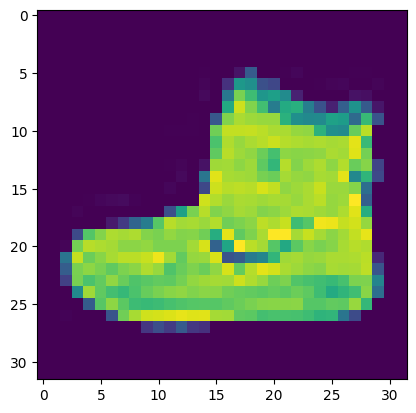

In [5]:
plt.imshow(trainset[0][0].permute(1,2,0))

In [6]:
def make_dir():
    image_dir = 'FashionMNIST_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

In [7]:
def save_decoded_image(img, epoch):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, './FashionMNIST_Images/linear_ae_image{}.png'.format(epoch))

In [8]:
class Encoder(nn.Module):
    def __init__(self, image_size=32, embedding_dim=4, channels=1):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.shape_before_flattening = (128, 4, 4)
        flattened_size = np.prod(self.shape_before_flattening)
        self.fc = nn.Linear(flattened_size, embedding_dim)
    def forward(self, x):
        x = self.encoder(x)
        self.shape_before_flattening = x.shape[1:]
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [9]:
class Decoder(nn.Module):
    def __init__(self, shape_before_flattening=(128, 4, 4), embedding_dim=4, channels=1):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=embedding_dim, out_features=2048)
        self.reshape_dim = shape_before_flattening
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(32, channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), *self.reshape_dim)
        x = self.decoder(x)
        return x

In [10]:
CNNencoder = Encoder()
dummy_input = torch.randn(4, 1, 32, 32)
encoded = CNNencoder(dummy_input)
print(CNNencoder.shape_before_flattening)
CNNdecoder = Decoder()
output = CNNdecoder(encoded)

torch.Size([128, 4, 4])


In [11]:
def save_decoded_image_cnn(img, epoch):
    img = img.view(img.size(0), 1, 32, 32)
    save_image(img, './FashionMNIST_Images_CNN/linear_ae_image{}.png'.format(epoch))

In [12]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(list(CNNencoder.parameters()) + list(CNNdecoder.parameters()), lr=LEARNING_RATE)

In [13]:
def train_cnn(encoder, decoder, trainloader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data
            optimizer.zero_grad()
            encoded = encoder(img)
            decoded = decoder(encoded)
            loss = loss_fn(decoded, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))
        # if epoch % 5 == 0:
            # save_decoded_image_cnn(decoded.data, epoch)
    return train_loss

def test_image_reconstruction_CNN(encoder, decoder, testloader):
     for batch in testloader:
        img, _ = batch
        encoded = encoder(img)
        decoded = decoder(encoded)
        outputs = decoded.view(decoded.size(0), 1, 32, 32).cpu().data
        save_image(outputs, 'fashionmnist_reconstruction.png')
        break

Epoch 1 of 5, Train Loss: 0.228
Epoch 2 of 5, Train Loss: 0.228
Epoch 3 of 5, Train Loss: 0.227
Epoch 4 of 5, Train Loss: 0.227
Epoch 5 of 5, Train Loss: 0.227


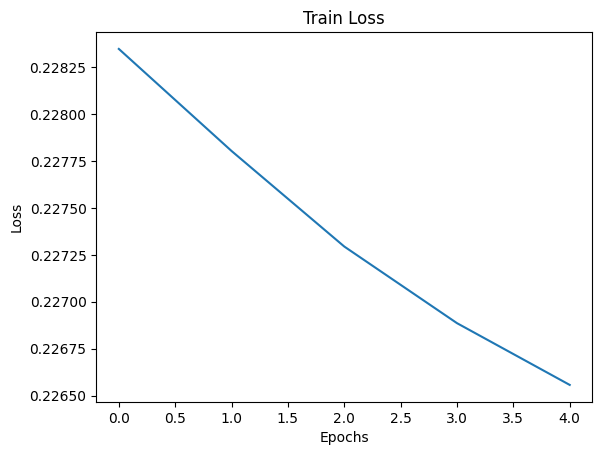

In [17]:
make_dir()

train_loss = train_cnn(CNNencoder, CNNdecoder, trainloader, NUM_EPOCHS)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('deep_ae_fashionmnist_loss.png')


In [15]:
test_image_reconstruction_CNN(CNNencoder, CNNdecoder, testloader)

In [19]:
from ipywidgets import interactive

def plot(z1, z2, z3, z4):
    plt.figure(2)
    z = torch.Tensor([[z1, z2, z3, z4]])
    decoded = CNNdecoder(z)
    img = decoded.reshape(32, 32).to('cpu').detach().numpy()
    plt.imshow(img, cmap='gray')
    plt.show()

interactive_plot = interactive(plot, z1=(-2., 2., 0.01), z2=(-2., 2., 0.01), z3=(-2., 2., 0.01), z4=(-2., 2., 0.01))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='z1', max=2.0, min=-2.0, step=0.01), FloatSlider(valu…